In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set the temporary folder path of joblib (the path does not contain Chinese or other non-ASCII characters)
temp_folder = r'D:\comp90089'
os.makedirs(temp_folder, exist_ok=True)
os.environ['JOBLIB_TEMP_FOLDER'] = temp_folder

In [2]:
# Machine learning libraries
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    f1_score,
    auc,
)
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import joblib

In [3]:
# Function to clean column names
def clean_column_names(columns):
    """
    Replace problematic characters in column names with underscores.
    """
    return [
        str(col)
        .replace('[', '_')
        .replace(']', '_')
        .replace('<', '_')
        .replace('>', '_')
        .replace('/', '_')
        .replace(' ', '_')
        for col in columns
    ]

# Create the 'results' directory if it doesn't exist
os.makedirs('results', exist_ok=True)
# Create the 'result', 'results/rf', and 'results/xgb' directories if they don't exist
os.makedirs('results/rf', exist_ok=True)
os.makedirs('results/xgb', exist_ok=True)
os.makedirs('results/common', exist_ok=True)
os.makedirs('results/common/rf', exist_ok=True)
os.makedirs('results/common/xgb', exist_ok=True)

In [4]:
# Load the dataset
final_data = pd.read_csv('final_data_with_long_titles.csv')

# Display the first few rows
print("First 5 rows of the dataset:")
print(final_data.head())

# Check the shape of the dataset
print(f"Dataset shape: {final_data.shape}")

First 5 rows of the dataset:
   subject_id   hadm_id gender  age     classification  \
0    10000980  26913865      F   76  Only_hypertension   
1    10001217  24597018      F   55  Only_hypertension   
2    10001401  21544441      F   89  Only_hypertension   
3    10001884  26202981      F   76  Only_hypertension   
4    10002013  23581541      F   57  Only_hypertension   

   Intestinal infection due to Clostridium difficile[00845]  \
0                                                  0          
1                                                  0          
2                                                  0          
3                                                  0          
4                                                  0          

   Unspecified septicemia[0389]  \
0                             0   
1                             0   
2                             0   
3                             0   
4                             0   

   Streptococcus infection in co

Missing values in each feature:
Series([], dtype: int64)

Total missing values in X: 0
Class distribution in the target variable:
stroke
0    57026
1     1725
Name: count, dtype: int64


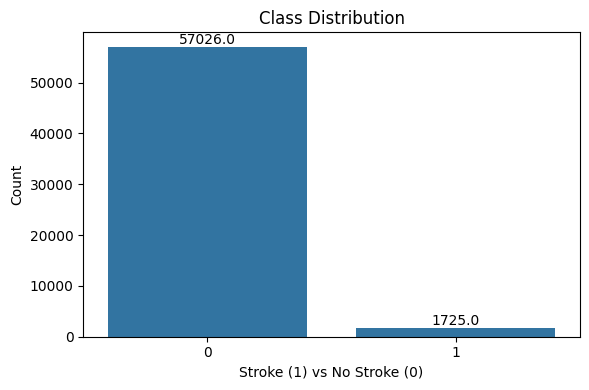

Class distribution after resampling:
stroke
0    57026
1    57026
Name: count, dtype: int64
Training set size: (91241, 282)
Testing set size: (22811, 282)


In [5]:
# Create target variable 'stroke'
# If 'classification' == 'stroke_after_hypertension', then stroke = 1, else stroke = 0
final_data['stroke'] = np.where(final_data['classification'] == 'stroke_after_hypertension', 1, 0)

# Drop unnecessary columns
data = final_data.drop(columns=['subject_id', 'hadm_id', 'classification'])

# Handle missing values in 'age' by filling with mean
data['age'] = data['age'].fillna(data['age'].mean())

# Encode 'gender'
data['gender'] = data['gender'].map({'M': 0, 'F': 1})

# Store original feature names before cleaning
original_feature_names = data.drop('stroke', axis=1).columns.tolist()

# Clean column names to remove problematic characters
cleaned_feature_names = clean_column_names(original_feature_names)

# Create a mapping from cleaned names to original names
cleaned_to_original = dict(zip(cleaned_feature_names, original_feature_names))

# Assign cleaned feature names to the DataFrame
data_cleaned = data.copy()
data_cleaned.columns = clean_column_names(data_cleaned.columns)

# Ensure ICD code columns are numeric
icd_columns_cleaned = [col for col in data_cleaned.columns if col.startswith('ICD_')]
data_cleaned[icd_columns_cleaned] = data_cleaned[icd_columns_cleaned].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

# Separate features and target
X = data_cleaned.drop('stroke', axis=1)
y = data_cleaned['stroke']

# Check for missing values in X
missing_values = X.isnull().sum()
print("Missing values in each feature:")
print(missing_values[missing_values > 0])

# Alternatively, check the total number of missing values in X
total_missing = X.isnull().sum().sum()
print(f"\nTotal missing values in X: {total_missing}")

# Save class distribution to a text file
class_distribution = y.value_counts()
print("Class distribution in the target variable:")
print(class_distribution)

with open('results/class_distribution.txt', 'w') as f:
    f.write("Class distribution in the target variable:\n")
    f.write(class_distribution.to_string())

# Visualize class distribution with numerical labels
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=y)
plt.title('Class Distribution')
plt.xlabel('Stroke (1) vs No Stroke (0)')
plt.ylabel('Count')

# Add numerical labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('results/class_distribution.png')
plt.show()

# Handle missing values by filling all with 0
if total_missing > 0:
    X_filled = X.fillna(0)
    print("Total missing values after filling with 0:")
    print(X_filled.isnull().sum().sum())
else:
    X_filled = X.copy()

# Ensure no missing values after filling
assert X_filled.isnull().sum().sum() == 0, "Missing values still exist after filling!"

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_filled, y)

# New class distribution
resampled_distribution = pd.Series(y_resampled).value_counts()
print("Class distribution after resampling:")
print(resampled_distribution)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Random Forest Accuracy: 0.8405593792468545
Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.96      0.71      0.82     11406
           1       0.77      0.97      0.86     11405

    accuracy                           0.84     22811
   macro avg       0.86      0.84      0.84     22811
weighted avg       0.86      0.84      0.84     22811

Confusion Matrix for Random Forest:
 [[ 8125  3281]
 [  356 11049]]
Confusion Matrix for Random Forest:
[[ 8125  3281]
 [  356 11049]]


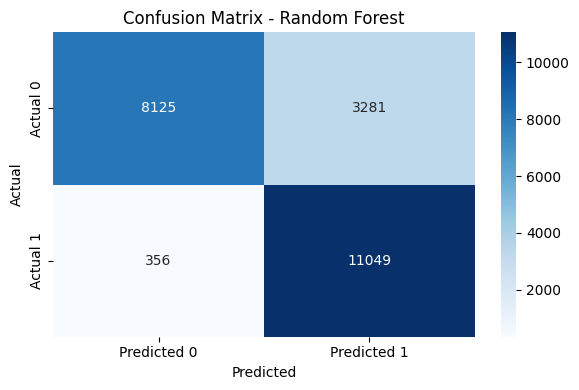

Random Forest ROC AUC Score: 0.90


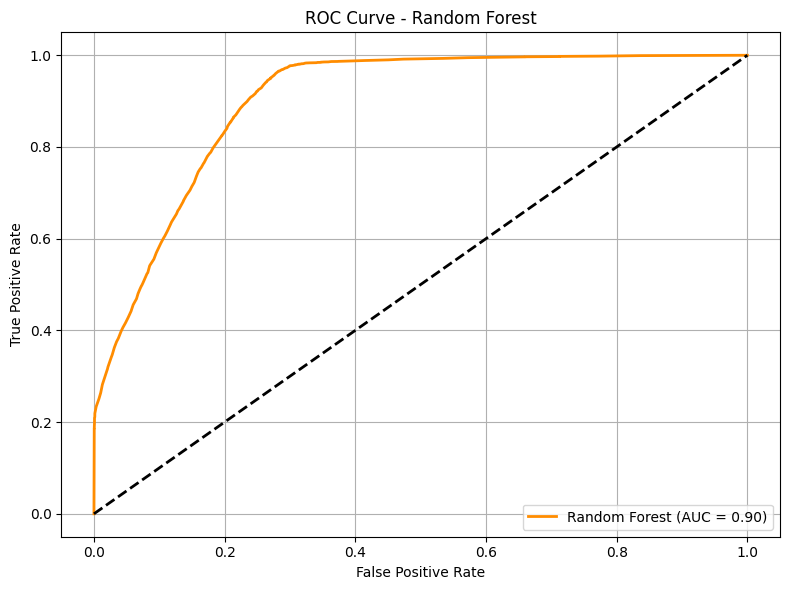

Random Forest Average Precision Score: 0.89


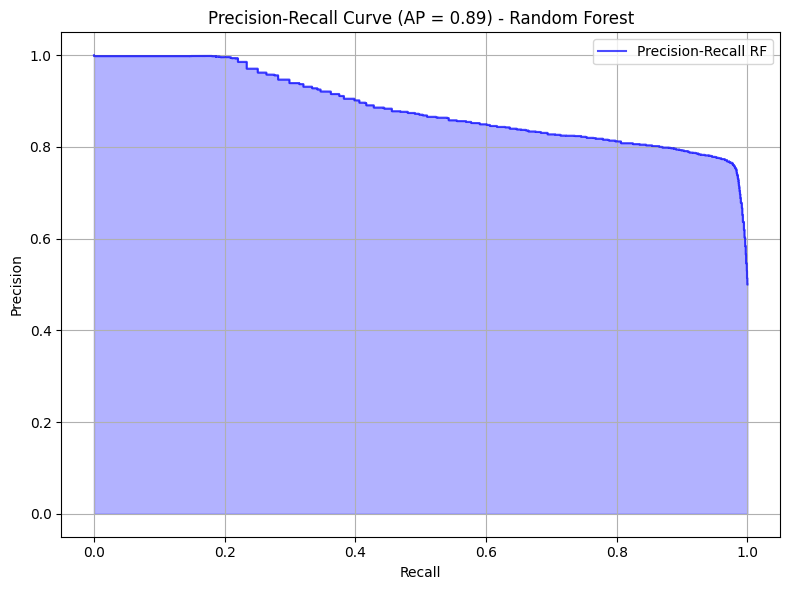

Random Forest F1 Score: 0.86
Top 50 Important Features - Random Forest:
 age                                                                                                                                                                         0.134618
Atrial_fibrillation_42731_                                                                                                                                                  0.025192
Acute_respiratory_failure_51881_                                                                                                                                            0.024929
Unspecified_essential_hypertension_4019_                                                                                                                                    0.021872
Acute_kidney_failure,_unspecified_5849_                                                                                                                                     0.021695
Unspecified_acquired_h

<ipython-input-6-50d511f0824e>:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp_rf_top_n.values, y=feat_imp_rf_top_n.index, palette='viridis')
<ipython-input-6-50d511f0824e>:89: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


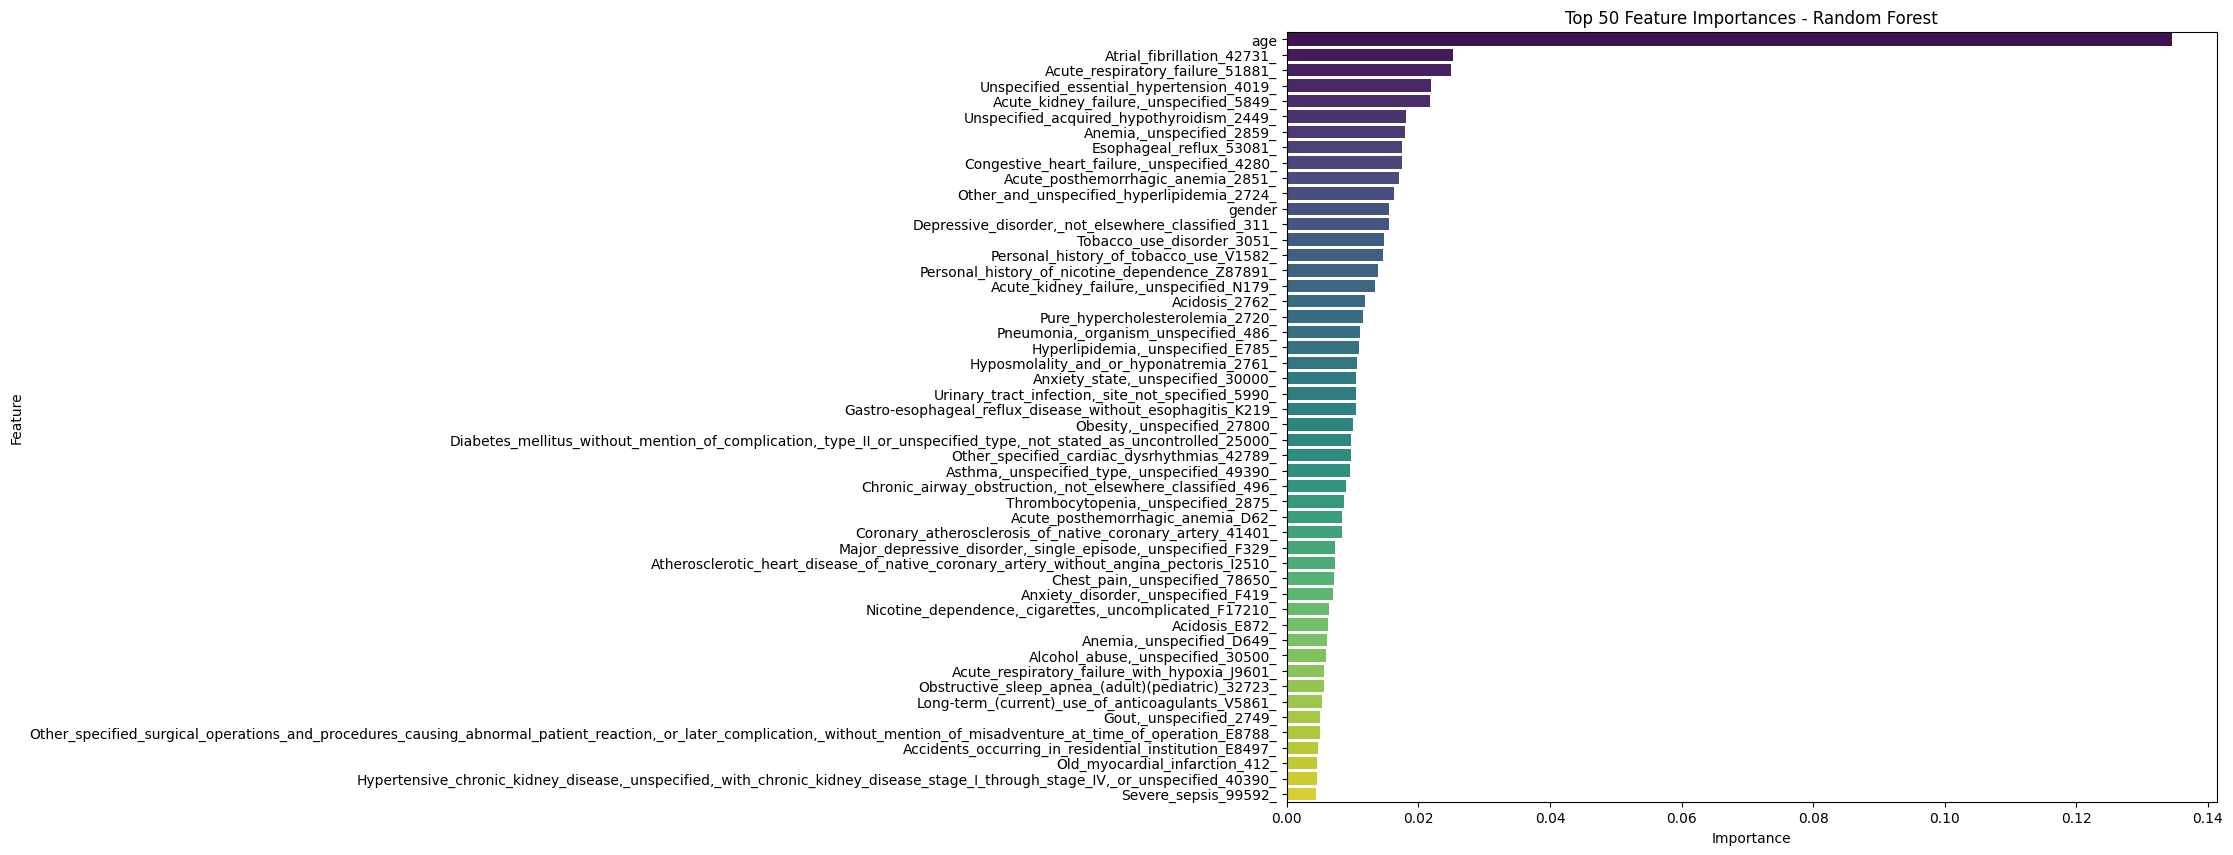

In [6]:
# ------------------------ Training the Random Forest model ------------------------

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and Evaluation for Random Forest
y_pred_rf = rf_model.predict(X_test)
print("\nRandom Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report for Random Forest:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix for Random Forest:\n", confusion_matrix(y_test, y_pred_rf))

# Confusion Matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix for Random Forest:")
print(conf_matrix_rf)


# Visualize Confusion Matrix with numerical labels for Random Forest
plt.figure(figsize=(6, 4))
ax = sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('results/rf/confusion_matrix_rf.png')
plt.show()

# ROC Curve for Random Forest
y_pred_rf_prob = rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_prob)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf_prob)
print(f"Random Forest ROC AUC Score: {roc_auc_rf:.2f}")


# Plot ROC Curve for Random Forest
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(roc_auc_rf), color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('results/rf/roc_curve_rf.png')
plt.show()

# Compute average precision for Random Forest
average_precision_rf = average_precision_score(y_test, y_pred_rf_prob)
print(f'Random Forest Average Precision Score: {average_precision_rf:.2f}')

# Plot Precision-Recall Curve for Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_rf_prob)
plt.figure(figsize=(8, 6))
plt.step(recall_rf, precision_rf, where='post', color='b', alpha=0.7, label='Precision-Recall RF')
plt.fill_between(recall_rf, precision_rf, step='post', alpha=0.3, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP = {average_precision_rf:.2f}) - Random Forest')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.savefig('results/rf/precision_recall_curve_rf.png')
plt.show()

# Calculate F1 Score for Random Forest
f1_rf = f1_score(y_test, y_pred_rf)
print(f"Random Forest F1 Score: {f1_rf:.2f}")

# Feature Importance from Random Forest
importances_rf = rf_model.feature_importances_
feature_names_rf = X.columns
feature_importances_rf = pd.Series(importances_rf, index=feature_names_rf).sort_values(ascending=False)

print("Top 50 Important Features - Random Forest:\n", feature_importances_rf.head(50))

# Plot Feature Importances for top 50 features - Random Forest
top_n = 50
feat_imp_rf_top_n = feature_importances_rf.head(top_n)

plt.figure(figsize=(12, 10))
sns.barplot(x=feat_imp_rf_top_n.values, y=feat_imp_rf_top_n.index, palette='viridis')
plt.title(f'Top {top_n} Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('results/rf/feature_importances_rf_top.png')
plt.show()

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:37:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.67      0.78     11406
           1       0.74      0.96      0.84     11405

    accuracy                           0.81     22811
   macro avg       0.84      0.81      0.81     22811
weighted avg       0.84      0.81      0.81     22811

Confusion Matrix - XGBoost:
[[ 7585  3821]
 [  481 10924]]


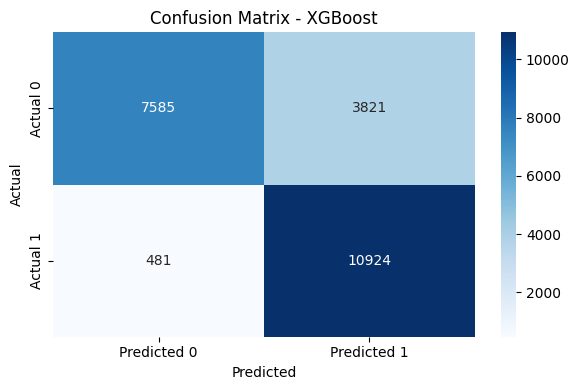

XGBoost ROC AUC Score: 0.86


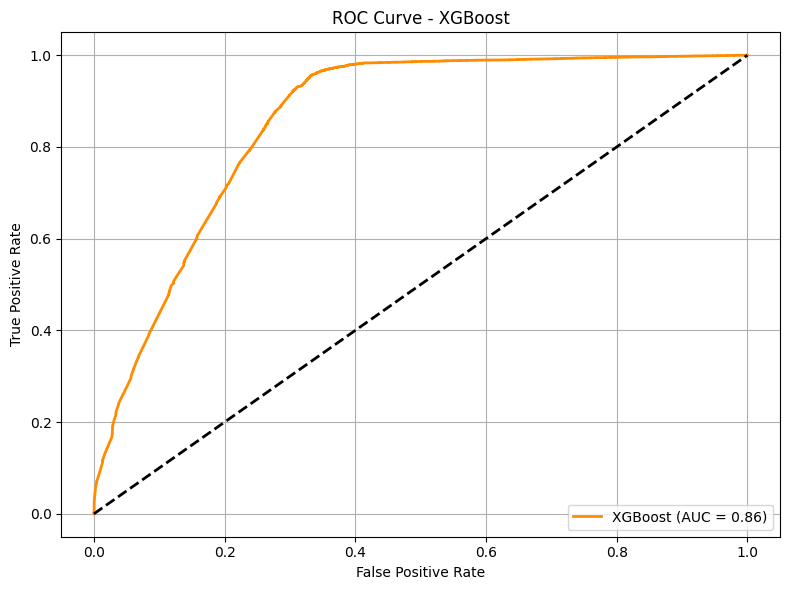

XGBoost Average Precision Score: 0.81


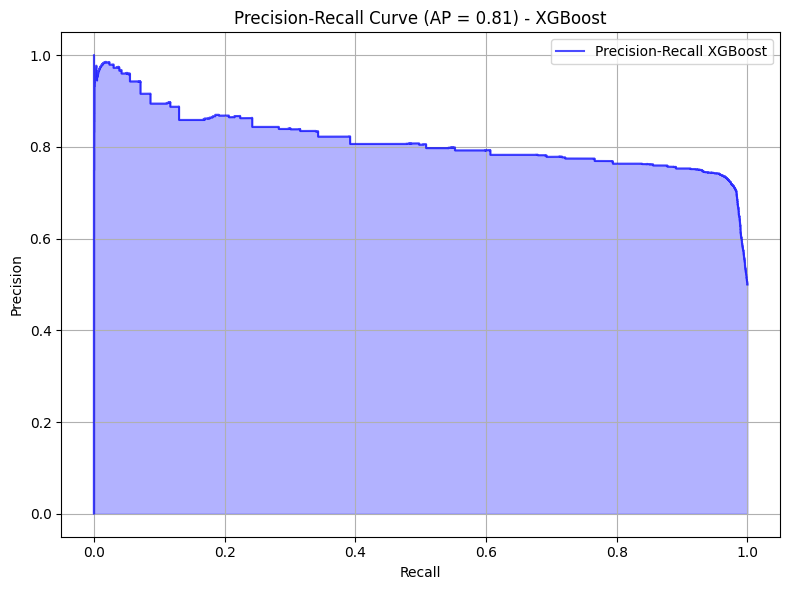

XGBoost F1 Score: 0.84


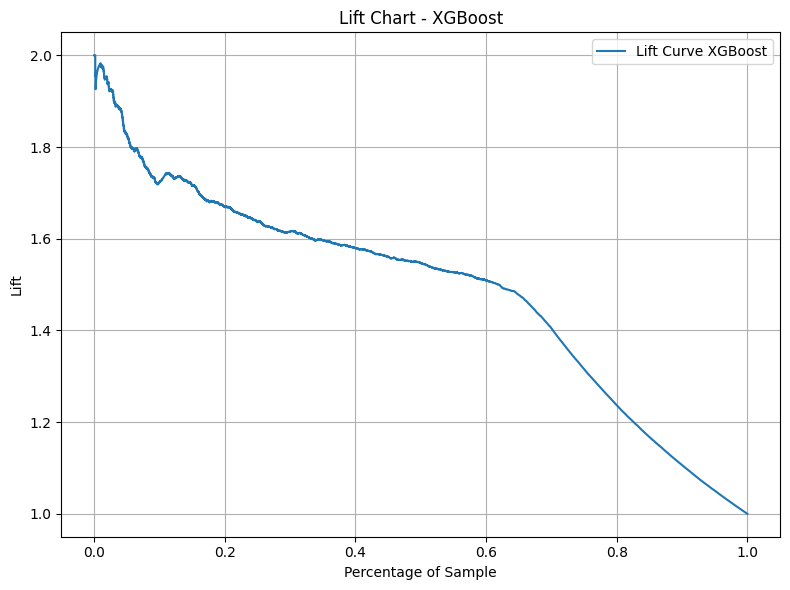

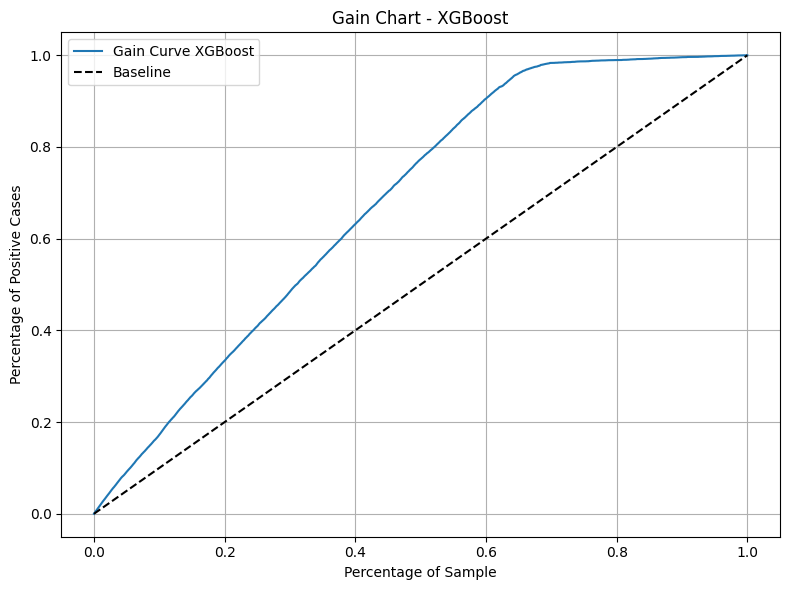


Top 50 Most Influential Features - XGBoost:
                                      Feature_Original  Importance
110                   Acute respiratory failure[51881]    0.017563
202                  Hyperlipidemia, unspecified[E785]    0.016172
100                     Hypotension, unspecified[4589]    0.014901
280    Personal history of nicotine dependence[Z87891]    0.014804
83                          Atrial fibrillation[42731]    0.014275
242            Acute kidney failure, unspecified[N179]    0.013329
35                  Acute posthemorrhagic anemia[2851]    0.012348
238      Acute respiratory failure with hypoxia[J9601]    0.011978
106  Chronic airway obstruction, not elsewhere clas...    0.011820
24                                      Acidosis[2762]    0.011283
187  Cardiac complications, not elsewhere classifie...    0.011177
38                           Anemia, unspecified[2859]    0.011005
86         Other specified cardiac dysrhythmias[42789]    0.010491
239  Gastro-esoph

<ipython-input-7-b89eed85f58b>:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature_Original', data=feat_imp_xgb_top_n, palette='viridis')
<ipython-input-7-b89eed85f58b>:139: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


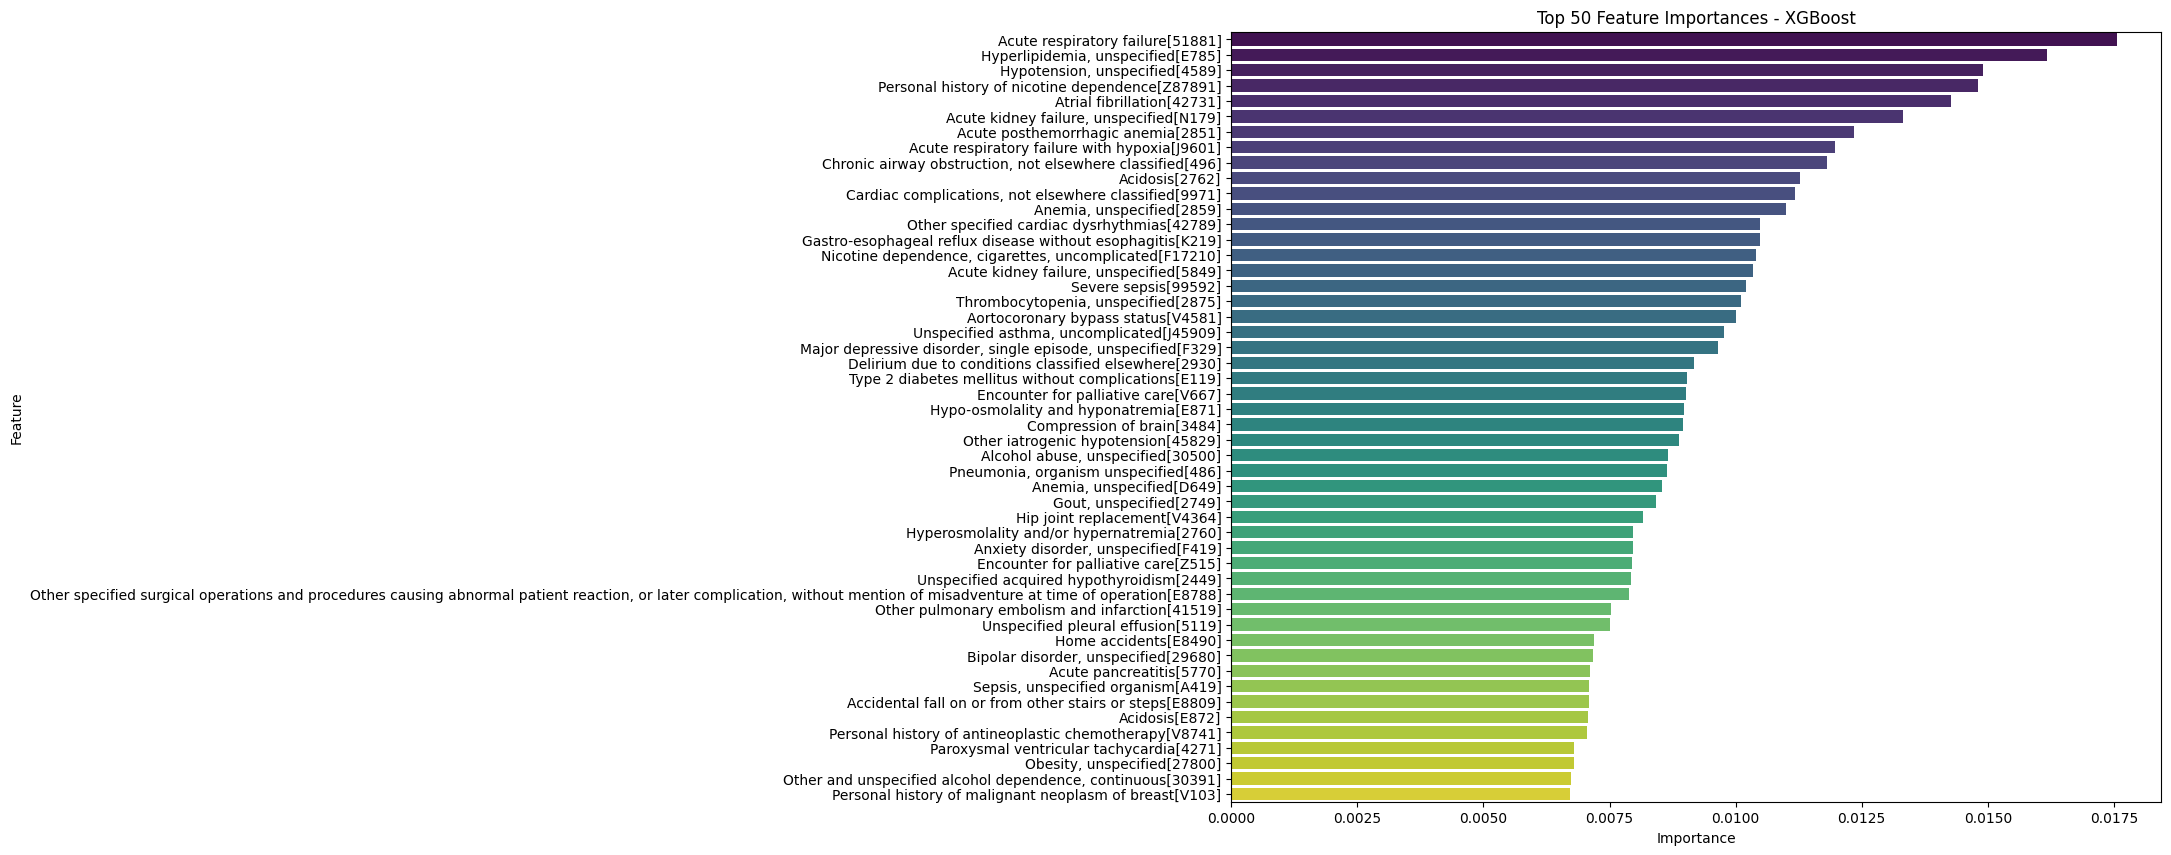

In [7]:
# ------------------------ Training the XGBoost model ------------------------

# Initialize and train the XGBoost model
model_xgb = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
model_xgb.fit(X_train, y_train)

# Predictions
y_pred_xgb = model_xgb.predict(X_test)
y_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]

# Classification report
classification_rep_xgb = classification_report(y_test, y_pred_xgb)
print("\nXGBoost Classification Report:")
print(classification_rep_xgb)

# Confusion Matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix - XGBoost:")
print(conf_matrix_xgb)

# Visualize Confusion Matrix with numerical labels - XGBoost
plt.figure(figsize=(6, 4))
ax = sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('results/xgb/confusion_matrix_xgb.png')
plt.show()

# Compute ROC AUC
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)
print(f"XGBoost ROC AUC Score: {roc_auc_xgb:.2f}")

# Plot ROC Curve - XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = {:.2f})'.format(roc_auc_xgb), color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('results/xgb/roc_curve_xgb.png')
plt.show()

# Compute average precision
average_precision_xgb = average_precision_score(y_test, y_proba_xgb)
print(f'XGBoost Average Precision Score: {average_precision_xgb:.2f}')

# Plot Precision-Recall Curve - XGBoost
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_proba_xgb)
plt.figure(figsize=(8, 6))
plt.step(recall_xgb, precision_xgb, where='post', color='b', alpha=0.7, label='Precision-Recall XGBoost')
plt.fill_between(recall_xgb, precision_xgb, step='post', alpha=0.3, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP = {average_precision_xgb:.2f}) - XGBoost')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.savefig('results/xgb/precision_recall_curve_xgb.png')
plt.show()

# Calculate F1 Score
f1_xgb = f1_score(y_test, y_pred_xgb)
print(f"XGBoost F1 Score: {f1_xgb:.2f}")

# Create a DataFrame with actual and predicted probabilities
lift_data_xgb = pd.DataFrame({'y_true': y_test, 'y_proba': y_proba_xgb})
lift_data_xgb = lift_data_xgb.sort_values('y_proba', ascending=False).reset_index(drop=True)
lift_data_xgb['cum_response'] = lift_data_xgb['y_true'].cumsum()
lift_data_xgb['cum_percentage'] = lift_data_xgb.index / len(lift_data_xgb)
lift_data_xgb['lift'] = lift_data_xgb['cum_response'] / (lift_data_xgb['cum_percentage'] * lift_data_xgb['y_true'].sum())

# Plot Lift Chart - XGBoost
plt.figure(figsize=(8, 6))
plt.plot(lift_data_xgb['cum_percentage'], lift_data_xgb['lift'], label='Lift Curve XGBoost')
plt.xlabel('Percentage of Sample')
plt.ylabel('Lift')
plt.title('Lift Chart - XGBoost')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('results/xgb/lift_chart_xgb.png')
plt.show()

# Plot Gain Chart - XGBoost
plt.figure(figsize=(8, 6))
plt.plot(lift_data_xgb['cum_percentage'], lift_data_xgb['cum_response'] / lift_data_xgb['y_true'].sum(), label='Gain Curve XGBoost')
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
plt.xlabel('Percentage of Sample')
plt.ylabel('Percentage of Positive Cases')
plt.title('Gain Chart - XGBoost')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('results/xgb/gain_chart_xgb.png')
plt.show()

# Get feature importances
importances_xgb = model_xgb.feature_importances_
features_xgb = X.columns.tolist()

# Create a DataFrame for feature importances
feat_imp_xgb_df = pd.DataFrame({'Feature_Cleaned': features_xgb, 'Importance': importances_xgb})
# Map cleaned feature names back to original names
feat_imp_xgb_df['Feature_Original'] = feat_imp_xgb_df['Feature_Cleaned'].map(cleaned_to_original)

# Sort features by importance
feat_imp_xgb_df = feat_imp_xgb_df.sort_values('Importance', ascending=False)

# Select top 50 features
top_n = 50
feat_imp_xgb_top_n = feat_imp_xgb_df.head(top_n)

# Display top features
print(f"\nTop {top_n} Most Influential Features - XGBoost:")
print(feat_imp_xgb_top_n[['Feature_Original', 'Importance']])

# Save feature importances to a CSV file
feat_imp_xgb_df.to_csv('results/xgb/feature_importances_xgb.csv', index=False)

# Plot Feature Importances for top 50 features - XGBoost
plt.figure(figsize=(12, 10))  # Increased figure size for better readability
sns.barplot(x='Importance', y='Feature_Original', data=feat_imp_xgb_top_n, palette='viridis')
plt.title(f'Top {top_n} Feature Importances - XGBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('results/xgb/feature_importances_xgb_top.png')
plt.show()

In [8]:
# ------------------------ Combine Top Features from Both Models ------------------------

# Define the number of top features to select from each model
N = 20

# Extract top N features from Random Forest
top_features_rf = feature_importances_rf.head(N).index.tolist()

# Extract top N features from XGBoost
top_features_xgb = feat_imp_xgb_df.head(N)['Feature_Cleaned'].tolist()

# Combine the features using set union
combined_features = list(set(top_features_rf) | set(top_features_xgb))
print(f"Total number of combined features: {len(combined_features)}")

Total number of combined features: 32


In [9]:
# ------------------------ Retrain Models with Selected Features ------------------------

# Subset the data to combined features
X_train_selected = X_train[combined_features]
X_test_selected = X_test[combined_features]

# Retrain Random Forest with selected features
rf_model_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_selected.fit(X_train_selected, y_train)
y_pred_rf_selected = rf_model_selected.predict(X_test_selected)
y_pred_rf_selected_prob = rf_model_selected.predict_proba(X_test_selected)[:, 1]

print("\nRandom Forest with Selected Features Accuracy:", accuracy_score(y_test, y_pred_rf_selected))
print("Classification Report:\n", classification_report(y_test, y_pred_rf_selected))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_rf_selected_prob))
print("F1 Score:", f1_score(y_test, y_pred_rf_selected))

# Save classification report to a text file
with open('results/common/rf/classification_report_rf_selected.txt', 'w') as f:
    f.write("Classification Report for Random Forest with Selected Features:\n")
    f.write(classification_report(y_test, y_pred_rf_selected))

# Retrain XGBoost with selected features
xgb_model_selected = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
xgb_model_selected.fit(X_train_selected, y_train)
y_pred_xgb_selected = xgb_model_selected.predict(X_test_selected)
y_pred_xgb_selected_prob = xgb_model_selected.predict_proba(X_test_selected)[:, 1]

print("\nXGBoost with Selected Features Accuracy:", accuracy_score(y_test, y_pred_xgb_selected))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb_selected))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_xgb_selected_prob))
print("F1 Score:", f1_score(y_test, y_pred_xgb_selected))

# Save classification report to a text file
with open('results/common/xgb/classification_report_xgb_selected.txt', 'w') as f:
    f.write("Classification Report for XGBoost with Selected Features:\n")
    f.write(classification_report(y_test, y_pred_xgb_selected))


Random Forest with Selected Features Accuracy: 0.7991758362193678
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.65      0.76     11406
           1       0.73      0.95      0.83     11405

    accuracy                           0.80     22811
   macro avg       0.83      0.80      0.79     22811
weighted avg       0.83      0.80      0.79     22811

ROC AUC Score: 0.8597418212016518
F1 Score: 0.8250391475384792


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:37:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost with Selected Features Accuracy: 0.7768182017447722
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.63      0.74     11406
           1       0.71      0.92      0.81     11405

    accuracy                           0.78     22811
   macro avg       0.80      0.78      0.77     22811
weighted avg       0.80      0.78      0.77     22811

ROC AUC Score: 0.8313875773789577
F1 Score: 0.8052782558806655


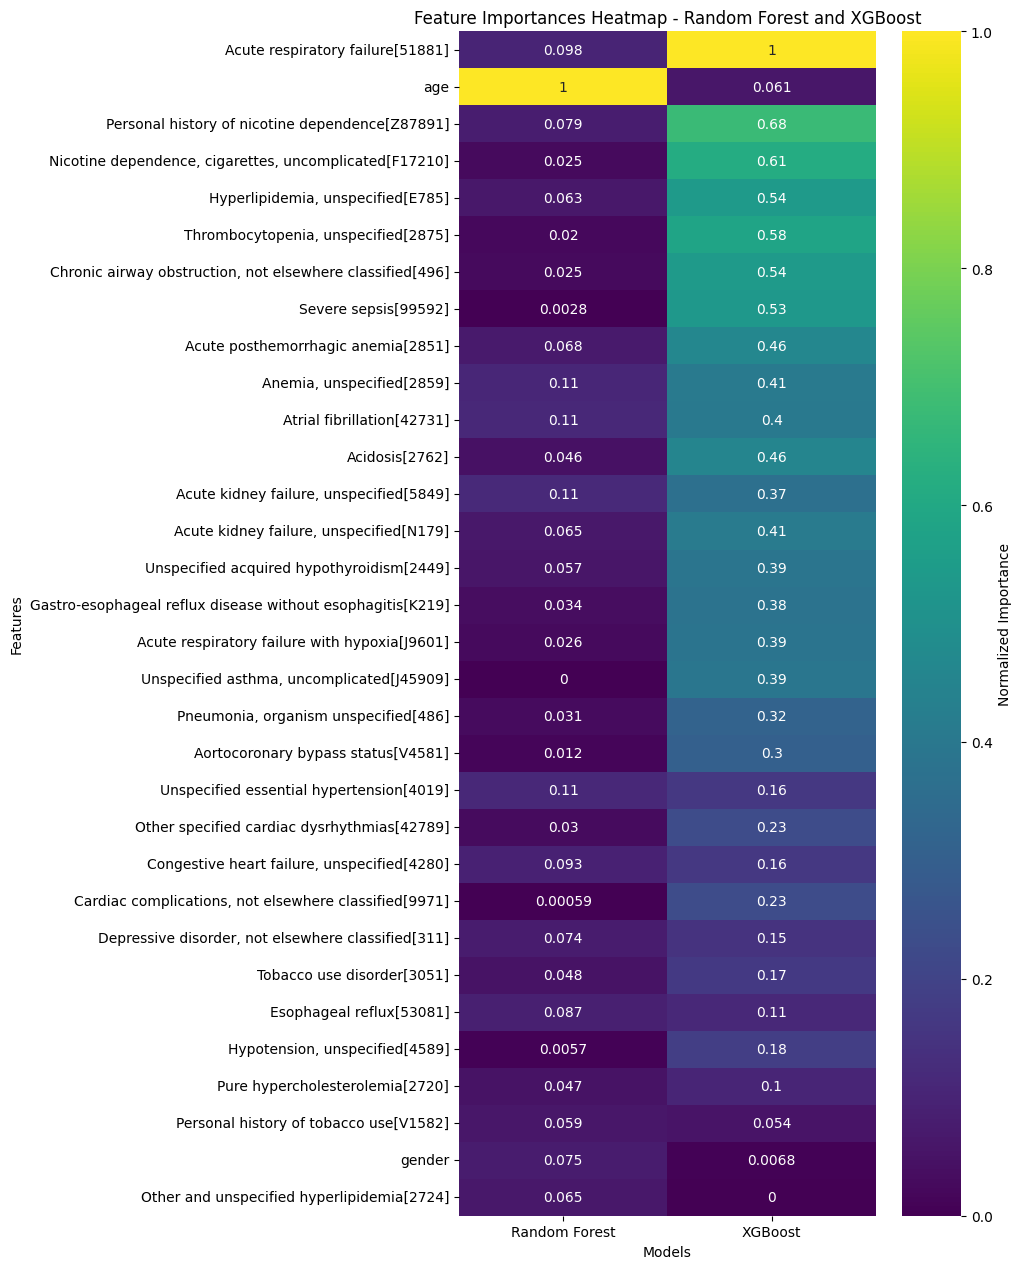

In [10]:
# ------------------------ Plotting Feature Importance Heatmap ------------------------

# Get the importance of selected features in both models
# For Random Forest
importances_rf_selected = rf_model_selected.feature_importances_
feature_importances_rf_selected = pd.Series(importances_rf_selected, index=combined_features).sort_values(ascending=False)

# For XGBoost
importances_xgb_selected = xgb_model_selected.feature_importances_
feature_importances_xgb_selected = pd.Series(importances_xgb_selected, index=combined_features).sort_values(ascending=False)

# Create a DataFrame containing the feature importances of the two models
feature_importances_df = pd.DataFrame({
    'Feature': combined_features,
    'Random Forest': feature_importances_rf_selected[combined_features],
    'XGBoost': feature_importances_xgb_selected[combined_features]
})

# Map cleaned feature names back to original names
feature_importances_df['Feature_Original'] = feature_importances_df['Feature'].map(cleaned_to_original)

# Set the feature name to index
feature_importances_df.set_index('Feature_Original', inplace=True)

from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Normalize feature importances for both models
feature_importances_normalized = scaler.fit_transform(feature_importances_df[['Random Forest', 'XGBoost']])

# Assign normalized values back to DataFrame
feature_importances_df[['Random Forest', 'XGBoost']] = feature_importances_normalized

# Calculate the average importance for sorting
feature_importances_df['Average_Importance'] = feature_importances_df[['Random Forest', 'XGBoost']].mean(axis=1)

# Sort the DataFrame based on Average_Importance in descending order
feature_importances_df_sorted = feature_importances_df.sort_values('Average_Importance', ascending=False)


feature_importances_df_sorted = feature_importances_df_sorted.drop('Average_Importance', axis=1)

# Heatmap with sorted features
plt.figure(figsize=(10, len(combined_features) * 0.4))  # Adjust height based on number of features
sns.heatmap(feature_importances_df_sorted[['Random Forest', 'XGBoost']], annot=True, cmap='viridis', cbar_kws={'label': 'Normalized Importance'})
plt.title('Feature Importances Heatmap - Random Forest and XGBoost')
plt.xlabel('Models')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('results/common/feature_importances_heatmap.png')
plt.show()

In [11]:
# ------------------------ Validate Features Using Cross-Validation ------------------------

from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}


# RF
scores_rf_cv = cross_validate(
    rf_model_selected,
    X_resampled[combined_features],
    y_resampled,
    cv=5,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

print("\nCross-Validation Metrics for Random Forest with Selected Features:")
print(f"Accuracy: {scores_rf_cv['test_accuracy']}")
print(f"Precision: {scores_rf_cv['test_precision']}")
print(f"Recall: {scores_rf_cv['test_recall']}")
print(f"F1 Score: {scores_rf_cv['test_f1']}")
print(f"ROC AUC: {scores_rf_cv['test_roc_auc']}")
print(f"Mean Accuracy: {scores_rf_cv['test_accuracy'].mean():.2f}")
print(f"Mean Precision: {scores_rf_cv['test_precision'].mean():.2f}")
print(f"Mean Recall: {scores_rf_cv['test_recall'].mean():.2f}")
print(f"Mean F1 Score: {scores_rf_cv['test_f1'].mean():.2f}")
print(f"Mean ROC AUC: {scores_rf_cv['test_roc_auc'].mean():.2f}")


# XGBoost
scores_xgb_cv = cross_validate(
    xgb_model_selected,
    X_resampled[combined_features],
    y_resampled,
    cv=5,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

print("\nCross-Validation Metrics for XGBoost with Selected Features:")
print(f"Accuracy: {scores_xgb_cv['test_accuracy']}")
print(f"Precision: {scores_xgb_cv['test_precision']}")
print(f"Recall: {scores_xgb_cv['test_recall']}")
print(f"F1 Score: {scores_xgb_cv['test_f1']}")
print(f"ROC AUC: {scores_xgb_cv['test_roc_auc']}")
print(f"Mean Accuracy: {scores_xgb_cv['test_accuracy'].mean():.2f}")
print(f"Mean Precision: {scores_xgb_cv['test_precision'].mean():.2f}")
print(f"Mean Recall: {scores_xgb_cv['test_recall'].mean():.2f}")
print(f"Mean F1 Score: {scores_xgb_cv['test_f1'].mean():.2f}")
print(f"Mean ROC AUC: {scores_xgb_cv['test_roc_auc'].mean():.2f}")



Cross-Validation Metrics for Random Forest with Selected Features:
Accuracy: [0.77524002 0.81237122 0.81560719 0.81350285 0.8100833 ]
Precision: [0.72517934 0.73750167 0.74385204 0.74072578 0.73819627]
Recall: [0.88636563 0.97001578 0.96273564 0.96466462 0.96098203]
F1 Score: [0.79771158 0.8379279  0.83925705 0.83799223 0.834984  ]
ROC AUC: [0.83562393 0.8715302  0.87278382 0.87380081 0.86905295]
Mean Accuracy: 0.81
Mean Precision: 0.74
Mean Recall: 0.95
Mean F1 Score: 0.83
Mean ROC AUC: 0.86

Cross-Validation Metrics for XGBoost with Selected Features:
Accuracy: [0.74757792 0.78882995 0.78974134 0.79017975 0.78671635]
Precision: [0.70157778 0.72168764 0.72290051 0.72359976 0.72038011]
Recall: [0.86163963 0.94029458 0.93967558 0.93906181 0.93722052]
F1 Score: [0.77341414 0.816614   0.81715593 0.81737007 0.81461723]
ROC AUC: [0.79811119 0.84410855 0.84530057 0.84644932 0.84021205]
Mean Accuracy: 0.78
Mean Precision: 0.72
Mean Recall: 0.92
Mean F1 Score: 0.81
Mean ROC AUC: 0.83


In [13]:
# ------------------------ Save Final Models ------------------------

# Save the trained models for future use
joblib.dump(rf_model_selected, 'results/common/rf_model_selected.pkl')
joblib.dump(xgb_model_selected, 'results/common/xgb_model_selected.pkl')
# ------------------------ Conclusion ------------------------

print("\nAll models have been retrained with the selected top features.")

print("The final models have been saved for future use.")

# ------------------------ End of Code ------------------------


All models have been retrained with the selected top features.
The final models have been saved for future use.
